<a href="https://colab.research.google.com/github/wangyeye66/projects/blob/main/Bank_Customer_Churn_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bank Customer Churn Prediction





In this project, we use supervised learning models to identify customers who are likely to churn in the future. Furthermore, we will analyze top factors that influence user retention. [Dataset information](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).

## Contents


* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)

# Part 0: Setup Google Drive Environment / Data Collection


In [1]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
id = "1szdCZ98EK59cfJ4jG03g1HOv_OhC1oyN"

file = drive.CreateFile({'id':id})
file.GetContentFile('bank.data.csv')

In [3]:
import numpy as np
import pandas as pd

churn_df = pd.read_csv('bank.data.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Part 1: EDA

In [4]:
# data info
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Understand the Categorical Data

In [5]:
#Distribution
churn_df['Exited'].value_counts(normalize=True)*100

0    79.63
1    20.37
Name: Exited, dtype: float64

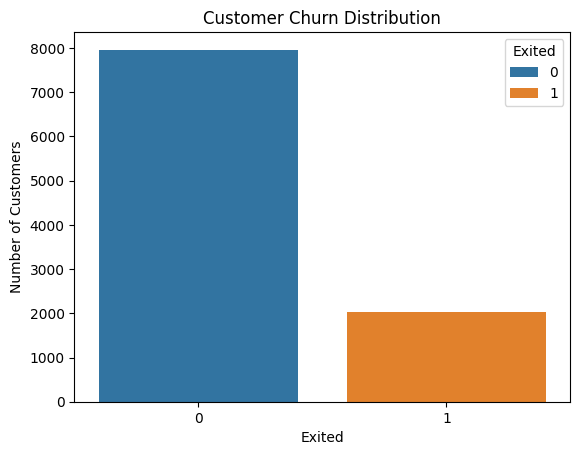

In [8]:
# Distribution
import seaborn as sns
import matplotlib.pyplot as plt

churn_df ['Exited'].value_counts(normalize=True)*100

sns.countplot(data=churn_df, x='Exited', hue='Exited')

plt.xlabel('Exited')
plt.ylabel('Number of Customers')
plt.title('Customer Churn Distribution')

plt.show()

- The churn rate is 20.37%

In [9]:
churn_df['Geography'].value_counts(normalize=True)*100

France     50.14
Germany    25.09
Spain      24.77
Name: Geography, dtype: float64

In [10]:
#Distribution of Customer Churn in different Geographies
churn_df.groupby('Geography')['Exited'].value_counts(normalize=True).mul(100)

Geography  Exited
France     0         83.845233
           1         16.154767
Germany    0         67.556796
           1         32.443204
Spain      0         83.326605
           1         16.673395
Name: Exited, dtype: float64

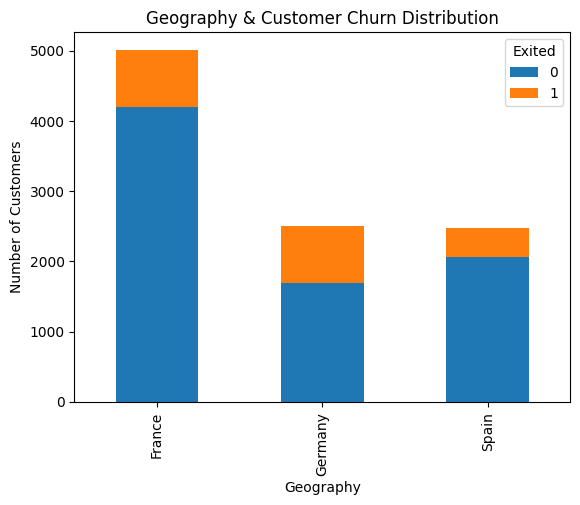

In [11]:
pd.crosstab(churn_df['Geography'], churn_df['Exited']).plot(kind='bar', stacked=True)

plt.xlabel('Geography')
plt.ylabel('Number of Customers')
plt.title('Geography & Customer Churn Distribution')

plt.show()

- The dataset provides insights into customer churn across France, Germany, and Spain. France represents half of the total customer base, while Germany and Spain each make up a quarter. Notably, Germany has the highest churn rate at 32%, double that of France and Spain, which both have churn rates around 16%.

In [12]:
#Distribution of Customer Churn between genders
churn_df.groupby('Gender')['Exited'].value_counts(normalize=True).mul(100)

Gender  Exited
Female  0         74.928461
        1         25.071539
Male    0         83.544072
        1         16.455928
Name: Exited, dtype: float64

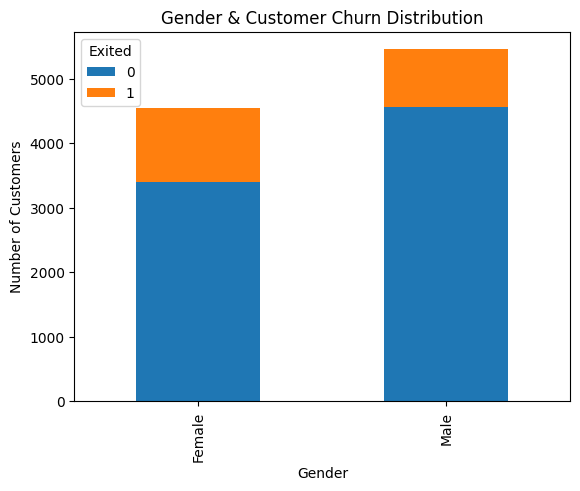

In [13]:
pd.crosstab(churn_df['Gender'], churn_df['Exited']).plot(kind='bar', stacked=True)

plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.title('Gender & Customer Churn Distribution')

plt.show()

- The customer base is 54% male and 45% female. Female customers exhibit a higher churn rate at 25%, compared to a 16% churn rate among male customers, indicating higher attrition among females.

In [14]:
# Numerical/Categorical Fetures
cat_feature = churn_df.select_dtypes(include = ['object']).columns.to_list()
numdis_feature= churn_df.select_dtypes(include = ['int64']).columns.to_list()
numcon_feature = churn_df.select_dtypes(include=['float64']).columns.to_list()

# Drop useless features
numdis_feature =numdis_feature[2:-1]
cat_feature = cat_feature[1:]

print('Categorical Features: ', cat_feature)
print('Discrete Features: ', numdis_feature)
print('Continuous Features: ', numcon_feature)

Categorical Features:  ['Geography', 'Gender']
Discrete Features:  ['CreditScore', 'Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
Continuous Features:  ['Balance', 'EstimatedSalary']


In [15]:
# Get target variable
y = churn_df['Exited']

In [16]:
# check missing values
churn_df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [17]:
# understand Numerical feature
churn_df[numcon_feature+numdis_feature].describe()

,Balance,EstimatedSalary,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,76485.889288,100090.239881,650.528800,38.921800,5.012800,1.530200,0.70550,0.515100
std,62397.405202,57510.492818,96.653299,10.487806,2.892174,0.581654,0.45584,0.499797
min,0.000000,11.580000,350.000000,18.000000,0.000000,1.000000,0.00000,0.000000
25%,0.000000,51002.110000,584.000000,32.000000,3.000000,1.000000,0.00000,0.000000
50%,97198.540000,100193.915000,652.000000,37.000000,5.000000,1.000000,1.00000,1.000000
75%,127644.240000,149388.247500,718.000000,44.000000,7.000000,2.000000,1.00000,1.000000
max,250898.090000,199992.480000,850.000000,92.000000,10.000000,4.000000,1.00000,1.000000


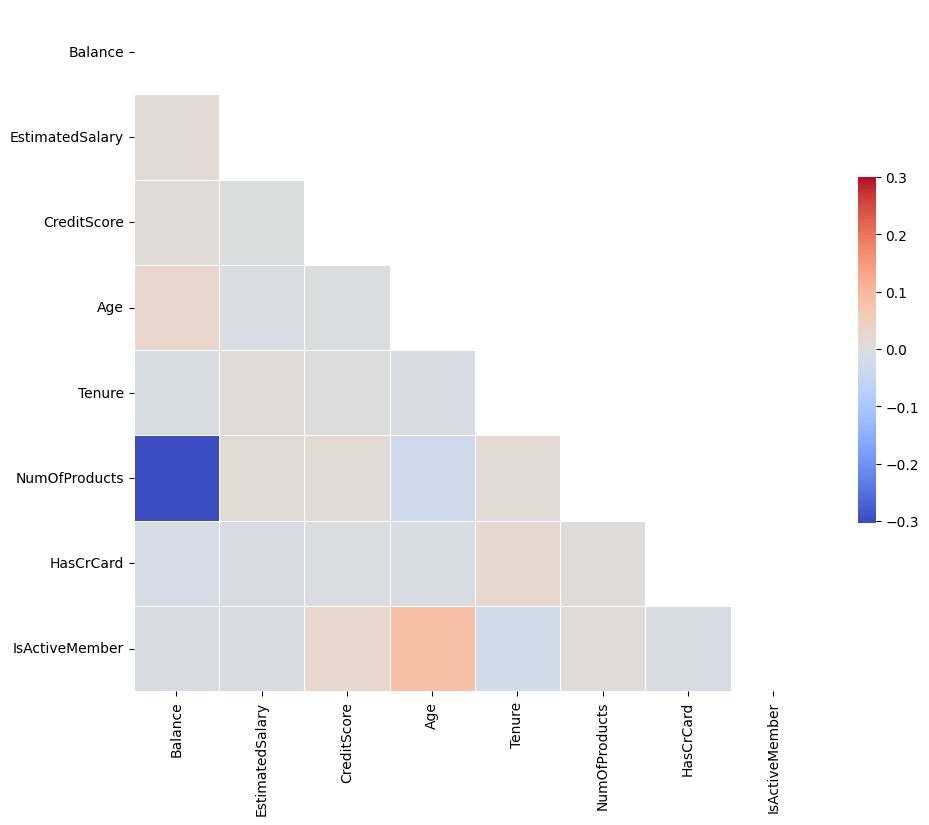

In [18]:
corr=churn_df[numcon_feature+numdis_feature].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

- Age and active membership status show a positive correlation.
- Account balance is negatively correlated with the number of products used by the user.
- However, no feature shows a strong correlation since the correlation coefficients range from -0.3 to 0.3 on the graph.

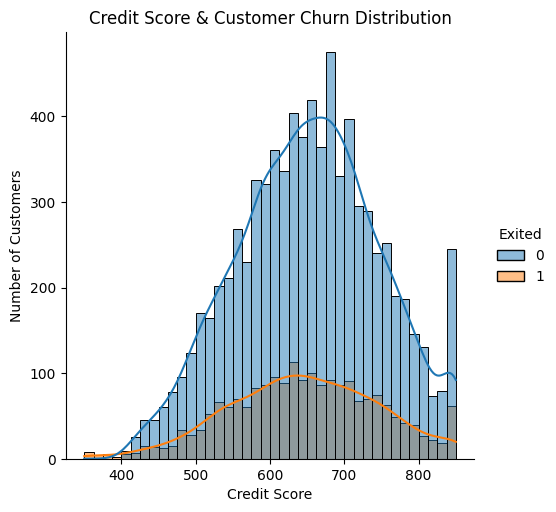

In [19]:
sns.displot(data=churn_df, x='CreditScore',hue='Exited', kde=True, bins=40)

plt.xlabel('Credit Score')
plt.ylabel('Number of Customers')
plt.title('Credit Score & Customer Churn Distribution')

plt.show()

- Customer credit scores vary between 350 and 850, indicating diverse creditworthiness. Customers with scores under 400 have universally churned, suggesting that low credit scores may be a key driver of attrition and warranting strategies to mitigate credit-related churn.

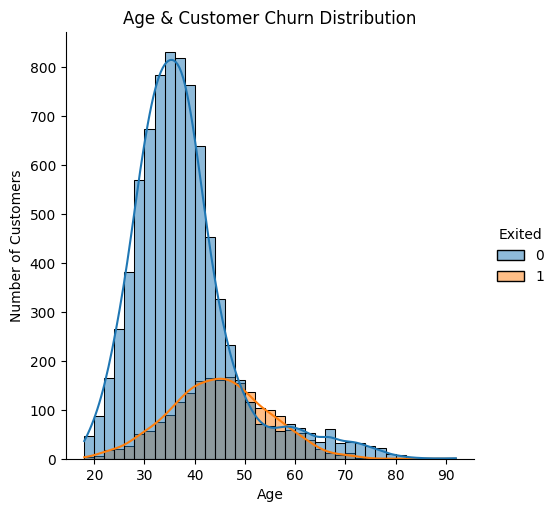

In [20]:
sns.displot(data=churn_df, x='Age', hue='Exited',kde=True, bins=37)

plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.title('Age & Customer Churn Distribution')

plt.show()

-  A notably high churn rate of 56% occurs in the 50-60 age bracket, suggesting that age-specific retention efforts may be needed. The age distribution is right-skewed, pointing to a smaller proportion of older customers and the relevance of age in churn analysis.

# Part 2: Feature Preprocessing

In [21]:
df = churn_df.copy()
X = df[cat_feature+numcon_feature+numdis_feature]
X.head()

,Geography,Gender,Balance,EstimatedSalary,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember
0,France,Female,0.00,101348.88,619,42,2,1,1,1
1,Spain,Female,83807.86,112542.58,608,41,1,1,0,1
2,France,Female,159660.80,113931.57,502,42,8,3,1,0
3,France,Female,0.00,93826.63,699,39,1,2,0,0
4,Spain,Female,125510.82,79084.10,850,43,2,1,1,1


Split dataset

In [22]:
from sklearn import model_selection

# Reserve 25% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state = 42)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 7500 observation with 10 features
test data has 2500 observation with 10 features


In [23]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns = enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

encoder = OneHotEncoder()
encoder.fit(X_train[cat_feature])

X_train = OneHotEncoding(X_train, encoder, cat_feature)
X_test = OneHotEncoding(X_test, encoder, cat_feature)

In [24]:
X_train.head()

,Balance,EstimatedSalary,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,123845.36,170454.93,735,53,8,2,0,1,1.0,0.0,0.0,1.0,0.0
1,90957.81,162304.59,518,38,3,1,0,1,1.0,0.0,0.0,0.0,1.0
2,97382.53,195771.95,572,54,9,1,1,1,0.0,1.0,0.0,1.0,0.0
3,90413.12,20555.21,619,35,4,1,1,1,1.0,0.0,0.0,1.0,0.0
4,83807.86,112542.58,608,41,1,1,0,1,0.0,0.0,1.0,1.0,0.0


Standardize/Normalize Data

In [25]:
# Scale the data, using standardization

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[numcon_feature+numdis_feature])

X_train[numcon_feature+numdis_feature] = scaler.transform(X_train[numcon_feature+numdis_feature])
X_test[numcon_feature+numdis_feature] = scaler.transform(X_test[numcon_feature+numdis_feature])

In [26]:
X_train.head()

,Balance,EstimatedSalary,CreditScore,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.761715,1.237787,0.874378,1.328762,1.028955,0.803861,-1.554124,0.967204,1.0,0.0,0.0,1.0,0.0
1,0.234517,1.095526,-1.371272,-0.092881,-0.699103,-0.914771,-1.554124,0.967204,1.0,0.0,0.0,0.0,1.0
2,0.337508,1.679687,-0.812446,1.423538,1.374567,-0.914771,0.643449,0.967204,0.0,1.0,0.0,1.0,0.0
3,0.225786,-1.378660,-0.326061,-0.377209,-0.353492,-0.914771,0.643449,0.967204,1.0,0.0,0.0,1.0,0.0
4,0.119901,0.226947,-0.439896,0.191448,-1.390327,-0.914771,-1.554124,0.967204,0.0,0.0,1.0,1.0,0.0


# Part 3: Model Training and Result Evaluation

### Part 3.1: Model Training & Grid Search

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

random_state = 42

# Logistic Regression
classifier_logistic = LogisticRegression(random_state=random_state)

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# Random Forest
classifier_RF = RandomForestClassifier(random_state=random_state)

# XGBoost
classifier_XGB = XGBClassifier(random_state=random_state)

# LightGBM
classifier_lgbmc = LGBMClassifier(random_state=random_state)

TypeError: KNeighborsClassifier.__init__() got an unexpected keyword argument 'random_state'

Notes:

| Aspect                 | Logistic Regression                                  | KNN                                                   | Random Forest                                     | XGBoost                                              | LightGBM                                           |
|------------------------|-------------------------------------------------------|-------------------------------------------------------|----------------------------------------------------|------------------------------------------------------|----------------------------------------------------|
| **Data Size and Training Speed** | Efficient with small to medium datasets, but can struggle with very large datasets. | Less efficient with large datasets.                   | Can be computationally expensive with large datasets. | Highly efficient, preferable for large datasets.     | Extremely efficient, ideal for very large datasets.|
| **Accuracy vs Interpretability** | Good interpretability, but accuracy may be lower for non-linear problems. | Intuitive but may lack accuracy for complex problems. | Good balance between accuracy and interpretability. | High accuracy, complex models.                        | High accuracy, complex models.                     |
| **Feature Relationships**        | Best for linear relationships between features and the target. | Can model complex relationships but struggles with high-dimensional data. | Handles complex, non-linear relationships well.    | Excellent at capturing complex, non-linear relationships. | Efficient in handling complex, non-linear relationships. |
| **Handling Missing Data**        | Requires complete data or imputation before training. | Requires complete data or imputation.                 | Handles missing values internally, but less efficiently. | Can handle missing data internally.                   | Can handle missing data internally with high efficiency. |

In [28]:
from sklearn.model_selection import GridSearchCV

# choose accuracy as metric
scoring_metric ='accuracy'

def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

In [32]:
# Grid Search Logistic Regression
param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': [ 'liblinear']
}

lr_clf = GridSearchCV(estimator=classifier_logistic,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

# Fit the GridSearchCV object to the training data
best_lr= lr_clf.fit(X_train, y_train)

print_grid_search_metrics(best_lr)


Best score: 0.812
Best parameters set:
C:0.1
max_iter:100
penalty:l1
solver:liblinear


In [30]:
# Grid Search for KNN
parameters = {
    'n_neighbors':[i for i in range(1,15)]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
best_knn = Grid_KNN.fit(X_train, y_train)

print_grid_search_metrics(best_knn)

Best score: 0.8377333333333334
Best parameters set:
n_neighbors:13


In [31]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=classifier_RF,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf = rf_clf.fit(X_train, y_train)
print_grid_search_metrics(best_rf)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best score: 0.8513333333333334
Best parameters set:
bootstrap:True
criterion:entropy
max_depth:6
max_features:auto
min_samples_leaf:2
min_samples_split:5
n_estimators:100


In [33]:
# XGB

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=classifier_XGB,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb = xgb_clf.fit(X_train, y_train)
print_grid_search_metrics(best_xgb)

Best score: 0.7966666666666666
Best parameters set:
colsample_bytree:0.75
gamma:0.1
learning_rate:0.01
max_depth:4
min_child_weight:1
n_estimators:50
reg_alpha:1
reg_lambda:1
subsample:0.75


In [37]:
param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=classifier_lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc= lgbmc_clf.fit(X_train, y_train)
print_grid_search_metrics(best_lgbmc)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 1528, number of negative: 5972
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 863
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203733 -> initscore=-1.363122
[LightGBM] [Info] Start training from score -1.363122
Best score: 0.8493333333333333
Best parameters set:
feature_fraction:0.5
learning_rate:0.01
max_depth:5
min_child_samples:10
n_estimators:200
num_leaves:10
reg_alpha:0.1
reg_lambda:0.5


In [39]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


print('✔️ Function Defined!')

✔️ Function Defined!


(0.0, 1.0, 0.0, 1.0)

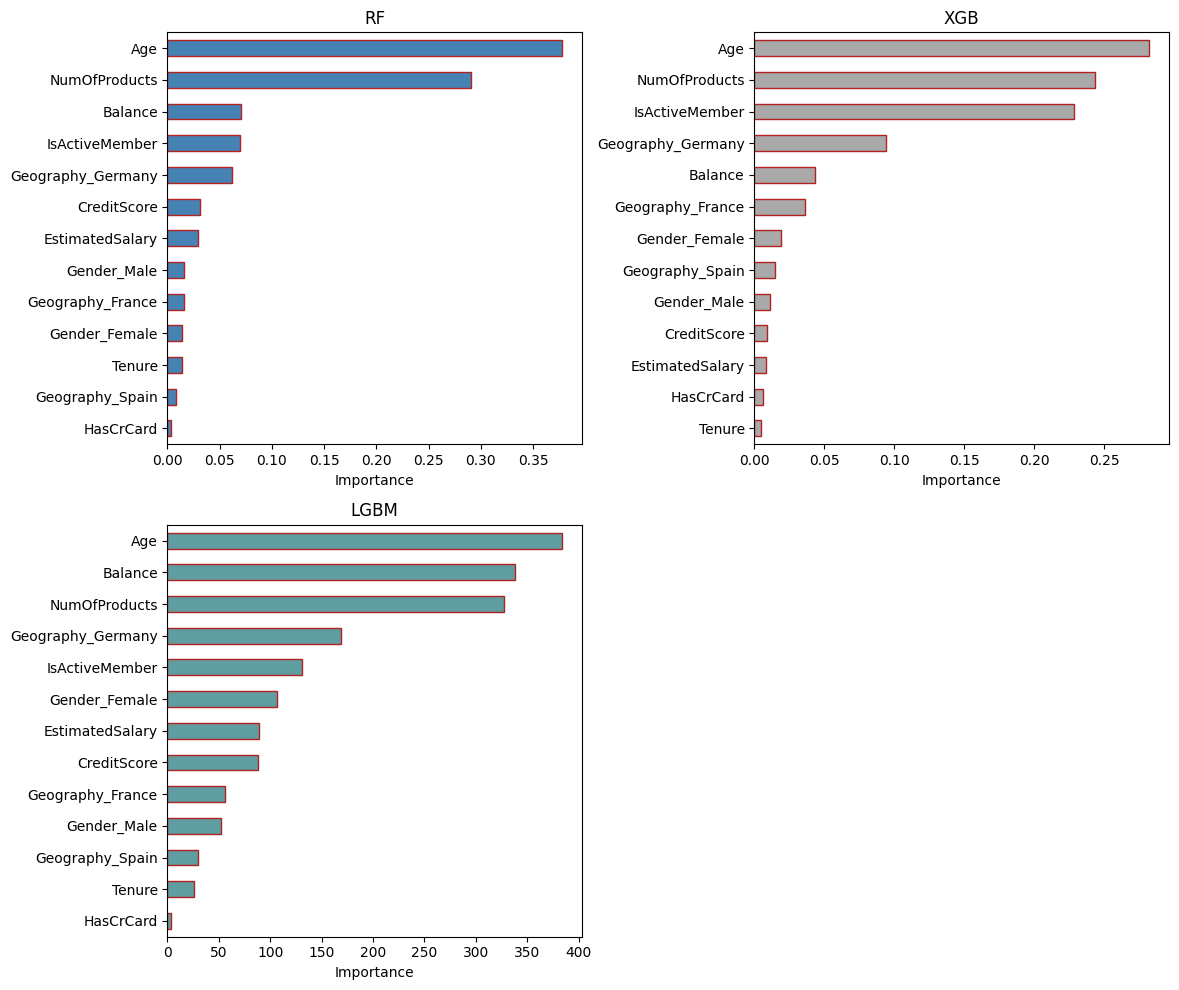

In [43]:
import matplotlib.pyplot as plt

# Assuming colors_fi is defined as you provided
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

# Initialize the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Model names and objects in a list for iteration
models = [('RF', best_rf), ('XGB', best_xgb), ('LGBM', best_lgbmc)]

# Loop through the models and plot feature importance
for i, (name, model) in enumerate(models):
    ax = axes.flatten()[i]
    plot_feature_imp(model, name, colors_fi[i], ax)
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()

axes.flatten()[-1].axis('off')  # This hides the fourth subplot


It seems that Age, Balance and NumOfProducts are most useful features for most classifiers

####Part 3.2: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)


---


**TP**: correctly labeled real churn

**Precision**(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users.


**Recall**(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [60]:
def calculate_percentages(conf_matrix):
    """
    Calculate the percentages of true positives (TP), false positives (FP),
    false negatives (FN), and true negatives (TN) from a confusion matrix.
    """
    tn, fp, fn, tp = conf_matrix.ravel()
    total = tn + fp + fn + tp
    percentages = {
        'TP': tp / total * 100,
        'FP': fp / total * 100,
        'FN': fn / total * 100,
        'TN': tn / total * 100
    }
    return percentages


- Show Confusion Matrices

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


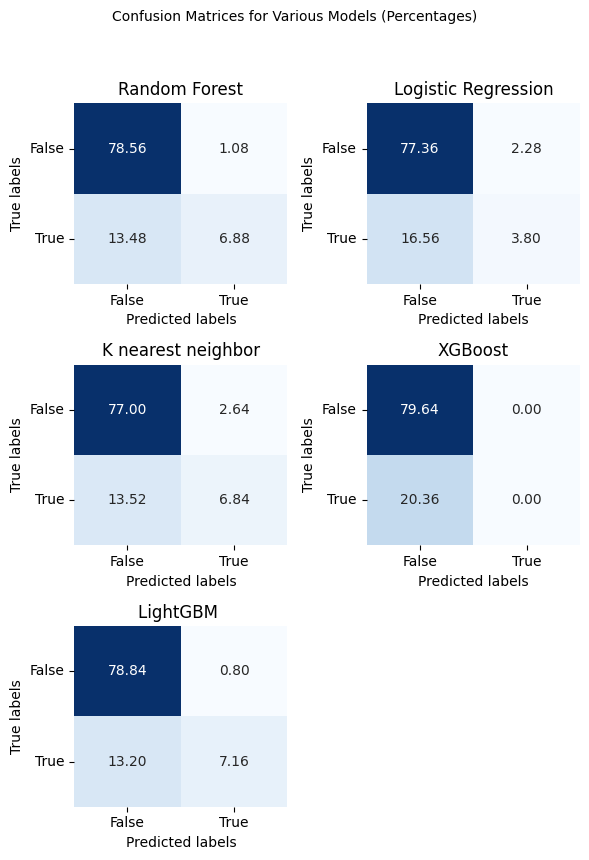

In [67]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_rf.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_lr.predict(X_test))),
    ("K nearest neighbor", confusion_matrix(y_test, best_knn.predict(X_test))),
    ("XGBoost", confusion_matrix(y_test, best_xgb.predict(X_test))),
    ("LightGBM ", confusion_matrix(y_test, best_lgbmc.predict(X_test))),
]

# Calculate and print percentages for each model's confusion matrix
confusion_matrices_percentages = [
    (name, matrix / np.sum(matrix) * 100) for name, matrix in confusion_matrices
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 9))
fig.suptitle('Confusion Matrices for Various Models (Percentages)', fontsize=10)

for i, (title, matrix) in enumerate(confusion_matrices_percentages):
    ax = axes.flatten()[i]
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(['False', 'True'])
    ax.set_yticklabels(['False', 'True'], rotation=0)

# Hide the last subplot (unused)
axes.flatten()[-1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Show Scores

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluates and prints the model's performance metrics: Accuracy, Precision, Recall, and AUC.
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    # For AUC, we need the probability scores of the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    # print(f'Accuracy: {accuracy:.4f}')
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'AUC: {auc:.4f}')\

    return [accuracy, precision, recall, auc]

score_rf = evaluate_model_performance(best_rf, X_test, y_test)
score_lr =evaluate_model_performance(best_lr, X_test, y_test)
score_knn =evaluate_model_performance(best_knn, X_test, y_test)
score_xbg =evaluate_model_performance(best_xgb, X_test, y_test)
score_lgbmc  =evaluate_model_performance(best_lgbmc, X_test, y_test)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x800 with 0 Axes>

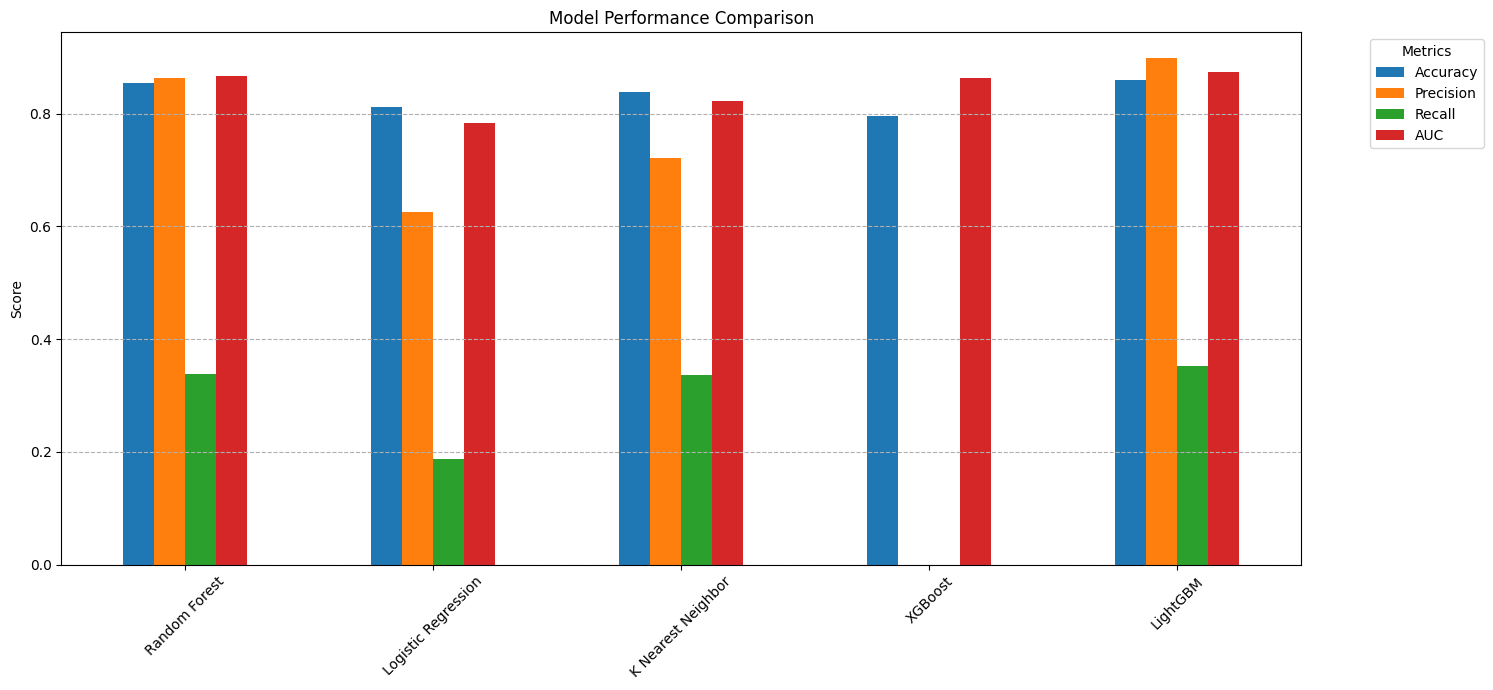

In [79]:
metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']

model_scores = {
    'Random Forest': score_rf,
    'Logistic Regression': score_lr,
    'K Nearest Neighbor': score_knn,
    'XGBoost': score_xbg,
    'LightGBM': score_lgbmc
}

# Convert to DataFrame for easier plotting
scores_df = pd.DataFrame(model_scores, index=metrics).T

# Plot
plt.figure(figsize=(10, 8))
scores_df.plot(kind='bar', figsize=(15, 7))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

### Part 3.3: Model Evaluation - ROC & AUC

#### Part 3.3.1: ROC of RF Model

In [85]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

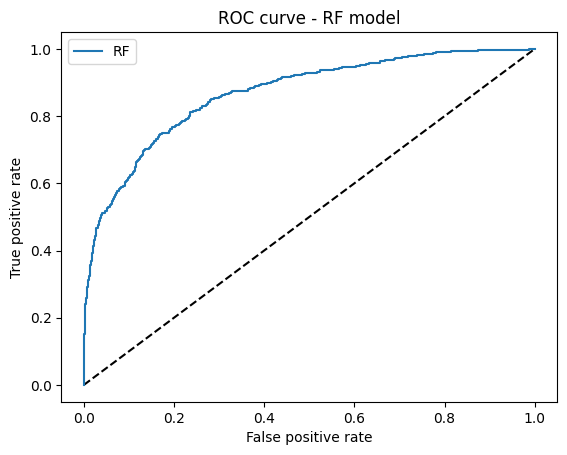

In [86]:
# ROC curve of Random Forest result
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [84]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.8674230500908311

#### Part 3.3.2: ROC of LR Model

In [87]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresh = roc_curve(y_test, y_pred_lr)

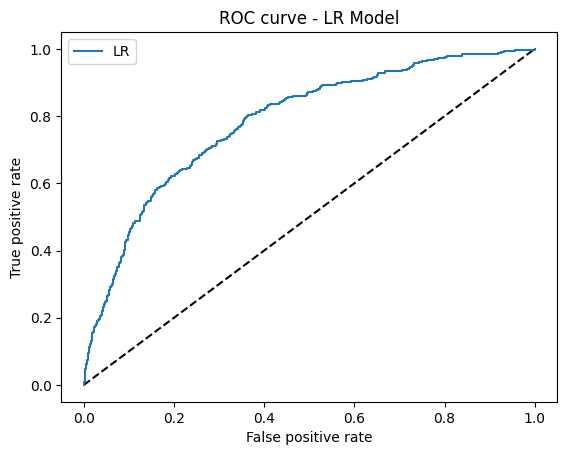

In [88]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [89]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.7844899296342381

#### Part 3.3.3: ROC of KNN Model

In [90]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_knn = best_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, thresh = roc_curve(y_test, y_pred_knn)

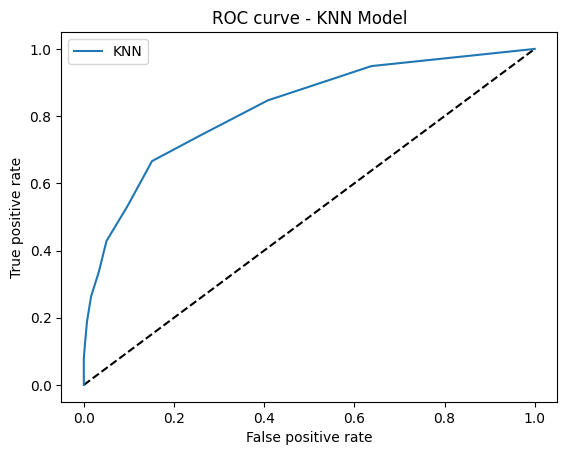

In [91]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN Model')
plt.legend(loc='best')
plt.show()

In [92]:
metrics.auc(fpr_knn,tpr_knn)

0.8232631320312724

#### Part 3.3.4: ROC of XGB Model

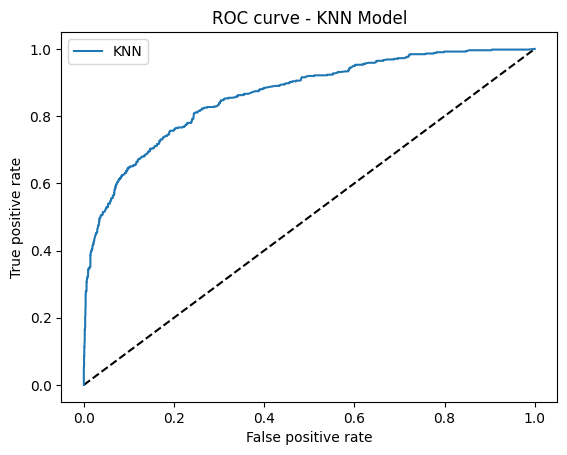

In [93]:
y_pred_xgb = best_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresh = roc_curve(y_test, y_pred_xgb)

# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN Model')
plt.legend(loc='best')
plt.show()

In [94]:
metrics.auc(fpr_xgb,tpr_xgb)

0.8633289883059229

#### Part 3.3.5: ROC of LGBM Model

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


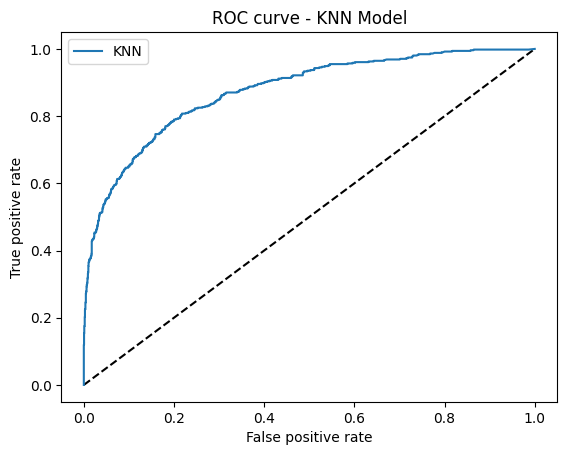

In [95]:
y_pred_lgbmc = best_lgbmc.predict_proba(X_test)[:, 1]
fpr_lgbmc, tpr_lgbmc, thresh = roc_curve(y_test, y_pred_lgbmc)

# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lgbmc, tpr_lgbmc, label='KNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - KNN Model')
plt.legend(loc='best')
plt.show()

In [97]:
metrics.auc(fpr_lgbmc,tpr_lgbmc)

0.8744137419961536